# Deep recommender on top of Amason’s Clean Clothing Shoes and Jewelry explicit rating dataset

Frame the recommendation system as a rating prediction machine learning problem and create a hybrid architecture that mixes the collaborative and content based filtering approaches:
- Collaborative part: Predict items ratings in order to recommend to the user items that he is likely to rate high.
- Content based: use metadata inputs (such as price and title) about items to find similar items to recommend.

### - Create 2 explicit recommendation engine models based on 2 machine learning architecture using Keras: 
    1. a matrix factorization model  
    2. a deep neural network model.


### Compare the results of the different models and configurations to find the "best" predicting model

### Used the best model for recommending items to users

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install sagemaker-experiments
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install boto3
!{sys.executable} -m pip install sagemaker
!{sys.executable} -m pip install pyspark
!{sys.executable} -m pip install ipython-autotime
!{sys.executable} -m pip install surprise
!{sys.executable} -m pip install smart_open
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install fastparquet

     |████████████████████████████████| 1.5MB 22.6MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Using cached sagemaker_experiments-0.1.13-py3-none-any.whl (35 kB)
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1837 sha256=78c82fa14a954eea42450ea1c3f94181b51b66758a84343cbd7ff19722cffc2f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/3a/38/7ecc013df8b58518cf859fb86c67c53df318426e96bb9fe1c0
Successfully built ipython-autotime
     |████████████████████████████████| 6.4 MB 13.7 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1778041 sha256=a48cabecbbe38deafd0cfd714523367e18b679302d2d93171b9f557a6226bd3d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f3/97/d9/6a242e5e3bb89377d4f575af72d14af0d54ebd90a525a4c2f9
Successfully built scikit-surprise
     |█████████████████████████

In [ ]:
# Check Jave version 
# !sudo yum -y update

In [2]:
# Need to use Java 1.8.0
!sudo yum remove jre-1.7.0-openjdk -y

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
Resolving Dependencies
--> Running transaction check
---> Package java-1.7.0-openjdk.x86_64 1:1.7.0.251-2.6.21.0.82.amzn1 will be erased
--> Finished Dependency Resolution

Dependencies Resolved

 Package            Arch   Version                          Repository     Size
Removing:
 java-1.7.0-openjdk x86_64 1:1.7.0.251-2.6.21.0.82.amzn1    @amzn-updates  91 M

Transaction Summary
Remove  1 Package

Installed size: 91 M
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Erasing    : 1:java-1.7.0-openjdk-1.7.0.251-2.6.21.0.82.amzn1.x86_64      1/1 
  Verifying  : 1:java-1.7.0-openjdk-1.7.0.251-2.6.21.0.82.amzn1.x86_64      1/1 

Removed:
  java-1.7.0-openjdk.x86_64 1:1.7.0.251-2.6.21.0.82.amzn1                       

Complete!


In [3]:
!java -version

openjdk version "11.0.1" 2018-10-16 LTS
OpenJDK Runtime Environment Zulu11.2+3 (build 11.0.1+13-LTS)
OpenJDK 64-Bit Server VM Zulu11.2+3 (build 11.0.1+13-LTS, mixed mode)


In [ ]:
# !sudo update-alternatives --config java

In [4]:
!pip install pyarrow fastparquet

In [5]:
!pip install ipython-autotime

In [7]:
!pip install tqdm pydot pydotplus pydot_ng

     |████████████████████████████████| 63 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 278 kB 10.7 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=23680 sha256=35b9c49f5d505b13fad6526b5948565f9973bb5b42efcce76c7f89e3b2025a92
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus
time: 3.89 s


In [6]:
#### To measure all running time
# https://github.com/cpcloud/ipython-autotime

%load_ext autotime

In [10]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np
from pandas import DataFrame 
import string
import pydot 
import pydotplus
import pydot_ng
import pickle
import time
import gzip
import os
os.getcwd()
    
import matplotlib.pyplot as plt
from math import floor,ceil

#from nltk.corpus import stopwords
#stop = stopwords.words("english")
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc,classification_report, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection  import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

#Keras
from keras.models import Sequential, Model, load_model, save_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot, Concatenate
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ceil', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



time: 18.6 s


Using TensorFlow backend.


### Set and Check GPUs

In [12]:
#Session
from keras import backend as K

def set_check_gpu():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction =1 # allow all of the GPU memory to be allocated
    # for 8 GPUs
    # cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    # for 1 GPU
    cfg.gpu_options.visible_device_list = "0"
    #cfg.gpu_options.allow_growth = True  # # Don't pre-allocate memory; dynamically allocate the memory used on the GPU as-needed
    #cfg.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras

    print("* TF version: ", [tf.__version__, tf.test.is_gpu_available()])
    print("* List of GPU(s): ", tf.config.experimental.list_physical_devices() )
    print("* Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) 
  
    
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # set for 8 GPUs
#     os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7";
    # set for 1 GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0";

    # Tf debugging option
    tf.debugging.set_log_device_placement(True)

    gpus = tf.config.experimental.list_physical_devices('GPU')

    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

#     print(tf.config.list_logical_devices('GPU'))
    print(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

time: 5.53 ms


In [13]:
set_check_gpu()

* TF version:  ['1.15.2', True]
* List of GPU(s):  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
* Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
time: 5.87 s


In [15]:
# reset GPU memory& Keras Session
def reset_keras():
    try:
        del classifier
        del model    
    except:
        pass

    K.clear_session()
 
    K.get_session().close()
#    sess = K.get_session()

    cfg = K.tf.ConfigProto()
    cfg.gpu_options.per_process_gpu_memory_fraction 
#     cfg.gpu_options.visible_device_list = "0,1,2,3,4,5,6,7" # "0,1"
    cfg.gpu_options.visible_device_list = "0" # "0,1"
    cfg.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    sess = K.tf.Session(config=cfg)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras
    

time: 2.4 ms


## Load dataset and analysis using Spark

## Download and prepare Data:
#### 1. Read the data:
#### Read the data from the reviews dataset of amazon. 
#### Use the dastaset in which all users and items have at least 5 reviews. 

### Location of dataset: https://nijianmo.github.io/amazon/index.html

In [16]:
import pandas as pd

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

import gzip
import json

from pyspark.ml import Pipeline
from pyspark.sql.types import StructField, StructType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator

import os
import pandas as pd
import pyarrow
import fastparquet

# from pandas_profiling import ProfileReport

time: 4.63 s


In [18]:
!pwd

/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender
time: 125 ms


In [17]:
# Download Clothing_Shoes_and_Jewelry_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Clothing_Shoes_and_Jewelry_5.json.gz -P /home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/

--2020-05-26 15:27:54--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Clothing_Shoes_and_Jewelry_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1262892731 (1.2G) [application/octet-stream]
Saving to: ‘Clothing_Shoes_and_Jewelry_5.json.gz’

lothing_Shoes_and_J 100%[===================>]   1.18G  12.0MB/s    in 60s     

2020-05-26 15:28:54 (20.1 MB/s) - ‘Clothing_Shoes_and_Jewelry_5.json.gz’ saved [1262892731/1262892731]

--2020-05-26 15:28:54--  http://./data
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-05-26 15:28:54--
Total wall clock time: 1m 0s
Downloaded: 1 files, 1.2G in 1m 0s (20.1 MB/s)
time: 1min


In [19]:
number_cores = 16
memory_gb = 64

spark = SparkSession \
    .builder \
    .appName("amazon recommendation") \
    .config("spark.driver.memory", '{}g'.format(memory_gb)) \
    .config("spark.master", 'local[{}]'.format(number_cores)) \
    .getOrCreate()

# get spark context
sc = spark.sparkContext

time: 14.7 s


#### Loading Clothing_Shoes_and_Jewelry_5.json.gz

In [20]:
DATA_PATH = './data/'
REVIEW_DATA = 'Clothing_Shoes_and_Jewelry_5.json.gz'

ratings = spark.read.load(DATA_PATH+REVIEW_DATA, format='json', header=True, inferSchema=True)
print(ratings.show(3))
print(type(ratings))
print(ratings.head(n=2))

+----------+-----+-------+--------------------+-----------+--------------+------------+--------------------+--------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|reviewerName|               style|       summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+------------+--------------------+--------------+--------------+--------+----+
|0871167042| null|    5.0|This book has bea...| 05 4, 2014|A2IC3NZN488KWK|  Ruby Tulip|[,,,,,,,,  Paperb...|Unique designs|    1399161600|    true|   2|
|0871167042| null|    5.0|Loved their appro...|03 31, 2014|A30FG02C424EJ5|NWCancerBaby|[,,,,,,,,  Paperb...|    Great Book|    1396224000|    true|null|
|0871167042| null|    5.0|               great|05 30, 2015|A2G9GWQEWWNQUB| Pamelarenee|[,,,,,,,,  Paperb...|    Five Stars|    1432944000|    true|null|
+----------+-----+-------+--------------------+-----------+--------------+--------

### Drop unuseful columns
-  'helpful'
- 'unixReviewTime'
- 'style'
- 'verified'
- 'vote'

In [21]:
clean_ratings = ratings.na.drop(how='any', subset='vote')
print(clean_ratings.columns)
product_ratings = clean_ratings.drop(
'helpful',
'unixReviewTime',
'style',
'verified',
'vote'
)

['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'style', 'summary', 'unixReviewTime', 'verified', 'vote']
time: 61.9 ms


In [22]:
print(product_ratings.columns)
print(product_ratings.show(3))
print(type(product_ratings))

['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary']
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|   reviewerName|             summary|
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+
|0871167042| null|    5.0|This book has bea...| 05 4, 2014|A2IC3NZN488KWK|     Ruby Tulip|      Unique designs|
|0871167042| null|    3.0|If you're an expe...|07 23, 2014|A1YIEW86G14BHP|      Aldne Now|     OK Jewelry Book|
|0871167042| null|    4.0|Hi, have been mak...| 06 5, 2014| AA7PNT2OPS3RP|Catherine Franz|Organic and upcyc...|
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+
only showing top 3 rows

None
<class 'pyspark.sql.dataframe.DataFrame'>
time: 191 ms


In [23]:
!rm -rf output

time: 130 ms


In [ ]:
## DONOT USE CSV..... SUCKS....
## create csv file
# product_ratings.write.csv("./Clean_Clothing_Shoes_and_Jewelry_5_clean")b

### CSV file format has limitation to hanlde big and complicated string data. Parquest is stong format.

In [24]:
product_ratings.write.parquet("data/Clothing_Shoes_and_Jewelry_5.parquet")

time: 1min 7s


In [25]:
!ls -ahl data/Clothing_Shoes_and_Jewelry_5.parquet

total 310M
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:34 .
drwxrwxr-x 4 ec2-user ec2-user 4.0K May 26 15:34 ..
-rw-r--r-- 1 ec2-user ec2-user 308M May 26 15:34 part-00000-2aae770e-5bd6-4aab-a74f-4dcb2218473b-c000.snappy.parquet
-rw-r--r-- 1 ec2-user ec2-user 2.4M May 26 15:34 .part-00000-2aae770e-5bd6-4aab-a74f-4dcb2218473b-c000.snappy.parquet.crc
-rw-r--r-- 1 ec2-user ec2-user    0 May 26 15:34 _SUCCESS
-rw-r--r-- 1 ec2-user ec2-user    8 May 26 15:34 ._SUCCESS.crc
time: 126 ms


### Upload parquet files into S3

In [26]:
!aws s3 cp ./data/Clothing_Shoes_and_Jewelry_5.parquet/*.parquet s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet

upload: data/Clothing_Shoes_and_Jewelry_5.parquet/part-00000-2aae770e-5bd6-4aab-a74f-4dcb2218473b-c000.snappy.parquet to s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet
time: 5.31 s


In [27]:
!aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet ./data/

download: s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet to data/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet
time: 2.66 s


In [29]:
!ls -alh ./data

total 1.5G
drwxrwxr-x 4 ec2-user ec2-user 4.0K May 26 15:35 .
drwxrwxr-x 5 ec2-user ec2-user 4.0K May 26 15:38 ..
-rw-rw-r-- 1 ec2-user ec2-user 308M May 26 15:35 Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet
-rw-rw-r-- 1 ec2-user ec2-user 1.2G Nov 21  2019 Clothing_Shoes_and_Jewelry_5.json.gz
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:34 Clothing_Shoes_and_Jewelry_5.parquet
-rw-rw-r-- 1 ec2-user ec2-user   31 May 26 15:34 for_dataset.txt
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:34 .ipynb_checkpoints
time: 127 ms


### Read clened dataset from parquet files

In [30]:
review_data = pd.read_parquet("./data/Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet")

time: 3.7 s


In [31]:
review_data[:3]

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,summary
0,0871167042,None,5.0,"This book has beautiful photos, good and under...","05 4, 2014",A2IC3NZN488KWK,Ruby Tulip,Unique designs
1,0871167042,None,3.0,"If you're an experienced wire jewelry maker, t...","07 23, 2014",A1YIEW86G14BHP,Aldne Now,OK Jewelry Book
2,0871167042,None,4.0,"Hi, have been making jewelry now for the last ...","06 5, 2014",AA7PNT2OPS3RP,Catherine Franz,Organic and upcycling jewelry maker


time: 56.9 ms


In [32]:
review_data.shape

(1069568, 8)

time: 3.05 ms


Thus I have 1069568 rows and 8 columns dataset.

## 2. Arrange and clean the data

Rearrange the columns by relevance and rename column names

In [33]:
review_data.columns

Index(['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary'],
      dtype='object')

time: 3.43 ms


In [34]:
review_data = review_data[['asin', 'image', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'reviewTime']]

review_data.rename(columns={ 'overall': 'score','reviewerID': 'user_id', 'reviewerName': 'user_name'}, inplace=True)

#the variables names after rename in the modified data frame
list(review_data)

['asin',
 'image',
 'summary',
 'reviewText',
 'score',
 'user_id',
 'user_name',
 'reviewTime']

time: 843 ms


## The Data analysis
### The datasets are composed of:

- “item_id”(“asin”): a unique id for an item - Independent explanatory variable
- “user_id”: a unique id for a user -Independent explanatory variable
- “score”(“overall”): the review score, between 1 and 5 - The dependent variable I want to predict
- “user_name”: the name of the user.
- “reviewTime”: the date when the user posted the review. Will not be used in this work.
- “reviewText”: For some entries, there is also a typed review. Will not be used in this work.
- “summary”: summary of the review. Will not be used in this work.


$\underline{Investigate}$:

In [35]:
# review_data["score"]

time: 755 µs


In [36]:
# Ratings distribution using pandas:
review_data["score"] = review_data["score"].fillna(review_data["score"].median()) 
review_data["score"].describe()

count    1.069568e+06
mean     4.045100e+00
std      1.307054e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: score, dtype: float64

time: 81 ms


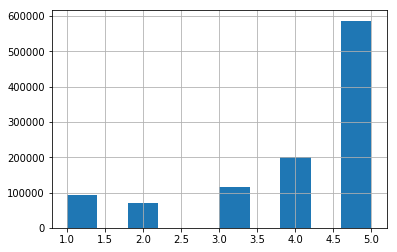

time: 658 ms


In [37]:
# Plot the distribution
review_data["score"].hist(bins=10)

## The median in both datasets is 5. This means that the data is skewed towards high ratings. 
This is a common bias in internet ratings, where people tend to rate items that they liked, and rarely spend time to comment something they dislike or are indiferent to. This will have a huge impact on the way I model the recommendation problem.

### Key conclusions from above: 

- Reviews are skewed towards positive
- Many people agree with score 5 reviews


# Add Metadata 

### Metadata includes descriptions, price, sales-rank, brand info, and co-purchasing links
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to

In [38]:
!pwd

/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender
time: 151 ms


In [39]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Clothing_Shoes_and_Jewelry.json.gz -P /home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/

--2020-05-26 15:40:22--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Clothing_Shoes_and_Jewelry.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1519327531 (1.4G) [application/octet-stream]
Saving to: ‘/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/meta_Clothing_Shoes_and_Jewelry.json.gz’

meta_Clothing_Shoes 100%[===================>]   1.41G  23.6MB/s    in 78s     

2020-05-26 15:41:41 (18.5 MB/s) - ‘/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/meta_Clothing_Shoes_and_Jewelry.json.gz’ saved [1519327531/1519327531]

time: 1min 18s


### Load meta_Clothing_Shoes_and_Jewelry.json.gz

In [40]:
all_info = spark.read.load('./data/meta_Clothing_Shoes_and_Jewelry.json.gz', format='json', header=True, inferSchema=True)

time: 1min 13s


In [41]:
all_info.columns

['also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'image',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'tech2',
 'title']

time: 56.7 ms


In [42]:
print(all_info.columns)
all_info = all_info.drop(
 'date',
 'details',
 'feature',
 'fit',
 'main_cat',
 'rank',
 'similar_item',
 'tech1',
 'tech2'
)
print(all_info.columns)

['also_buy', 'also_view', 'asin', 'brand', 'category', 'date', 'description', 'details', 'feature', 'fit', 'image', 'main_cat', 'price', 'rank', 'similar_item', 'tech1', 'tech2', 'title']
['also_buy', 'also_view', 'asin', 'brand', 'category', 'description', 'image', 'price', 'title']
time: 13.5 ms


### create parquet files to upload S3

In [43]:
!rm -rf ./data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet

time: 151 ms


In [44]:
# Save it as parquet format
all_info.write.parquet("data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet")

time: 2min 32s


In [45]:
!aws s3 cp ./data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet/*.parquet s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet

upload: data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet/part-00000-2e066c90-05e6-4a88-9be8-cf09240c74c3-c000.snappy.parquet to s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet
time: 17.7 s


In [46]:
!aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet ./data/

download failed: s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet to data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet [Errno 21] Is a directory: '/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet.Be81CDe7' -> '/home/ec2-user/SageMaker/dse260-CapStone-Amazon/2-**Final-Keras-DeepRecommender/data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet'
time: 10.6 s


In [47]:
all_info = pd.read_parquet("./data/Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet")

time: 31.7 s


In [48]:
all_info.head(n=5)

,also_buy,also_view,asin,brand,category,description,image,price,title
0,None,None,0000037214,Big Dreams,"[Clothing, Shoes & Jewelry, Costumes & Accesso...","[6"" long, stretched waist measures 11 1/2"" acr...",None,None,Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...
1,None,None,0201377179,Anello,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",[The Hottest Bag in Town! Brand: Anello Condit...,[https://images-na.ssl-images-amazon.com/image...,None,Japan Anello Backpack Unisex LARGE LIGHT GRAY ...
2,None,"[B07CJF5HLR, B01EBI8UH6, B01N1LR908, B074M4QKG...",0204444454,Anello,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",[The Hottest Bag in Town! Brand: Anello Condit...,[https://images-na.ssl-images-amazon.com/image...,$70.00,Japan Anello Backpack Unisex PINK BEIGE LARGE ...
3,None,"[B01DLVYOPG, B07CJF5HLR, B01MSS59Y6, B071YBC1J...",0204444403,Anello,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",[The Hottest Bag in Town! Brand: Anello Condit...,[https://images-na.ssl-images-amazon.com/image...,$65.99,Japan Anello Backpack Unisex BLACK LARGE PU LE...
4,None,"[B00VGT93YS, B07FTY87LM, B01IKVOY8E, B01GF6C6F...",0206313535,bettyhome,"[Clothing, Shoes & Jewelry, Novelty & More, Cl...",[Brand New. Hat Centre Length: adult about 8c...,[https://images-na.ssl-images-amazon.com/image...,$18.99,bettyhome Unisex Adult Winter Spring Thicken C...


time: 21.9 ms


### Arrange and clean the data

- Cleaning, handling missing data, normalization, etc:
- For the algorithm in keras to work,  remap all item_ids and user_ids to an interger between 0 and the total number of users or the total number of items

In [49]:
all_info.columns

Index(['also_buy', 'also_view', 'asin', 'brand', 'category', 'description',
       'image', 'price', 'title'],
      dtype='object')

time: 3.29 ms


In [50]:
items = all_info.asin.unique()
item_map = {i:val for i,val in enumerate(items)}
inverse_item_map = {val:i for i,val in enumerate(items)}
all_info["old_item_id"] = all_info["asin"] # copying for join with metadata
all_info["item_id"] = all_info["asin"].map(inverse_item_map)
items = all_info.item_id.unique()
print ("We have %d unique items in metadata "%items.shape[0])

We have 2681355 unique items in metadata 
time: 9.75 s


In [51]:
all_info['description'] = all_info['description'].fillna(all_info['title'].fillna('no_data'))
all_info['title'] = all_info['title'].fillna(all_info['description'].fillna('no_data').apply(str).str[:20])
all_info['image'] = all_info['image'].fillna('no_data')
all_info['price'] = pd.to_numeric(all_info['price'],errors="coerce")
all_info['price'] = all_info['price'].fillna(all_info['price'].median()) 

time: 56.6 s


In [52]:
users = review_data.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
review_data["old_user_id"] = review_data["user_id"] 
review_data["user_id"] = review_data["user_id"].map(inverse_user_map)

items_reviewed = review_data.asin.unique()
review_data["old_item_id"] = review_data["asin"] # copying for join with metadata
review_data["item_id"] = review_data["asin"].map(inverse_item_map)

items_reviewed = review_data.item_id.unique()
users = review_data.user_id.unique()

time: 8.93 s


In [53]:
print ("We have %d unique users"%users.shape[0])
print ("We have %d unique items reviewed"%items_reviewed.shape[0])
# We have 192403 unique users in the "small" dataset
# We have 63001 unique items reviewed in the "small" dataset

We have 513010 unique users
We have 245636 unique items reviewed
time: 1.82 ms


In [54]:
review_data.head(3)

,asin,image,summary,reviewText,score,user_id,user_name,reviewTime,old_user_id,old_item_id,item_id
0,0871167042,None,Unique designs,"This book has beautiful photos, good and under...",5.0,0,Ruby Tulip,"05 4, 2014",A2IC3NZN488KWK,0871167042,12
1,0871167042,None,OK Jewelry Book,"If you're an experienced wire jewelry maker, t...",3.0,1,Aldne Now,"07 23, 2014",A1YIEW86G14BHP,0871167042,12
2,0871167042,None,Organic and upcycling jewelry maker,"Hi, have been making jewelry now for the last ...",4.0,2,Catherine Franz,"06 5, 2014",AA7PNT2OPS3RP,0871167042,12


time: 14.8 ms


### Check the Distribution of number of ratings per user:

In [55]:
users_ratings = review_data['old_user_id'].value_counts().reset_index()
users_ratings.columns= ['old_user_id','num_ratings']
users_ratings['num_ratings'].describe()

count    513010.000000
mean          2.084887
std           2.329994
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         120.000000
Name: num_ratings, dtype: float64

time: 854 ms


### The distribution of number of ratings per user is very skewed in both datasets, with 50% of people having done a small number of reviews, and few made many ratings. 
### I will check if it gives us enough information for generating good recommendations.

### * Check the Distribution of the number of ratings per item:

In [56]:
#items_nb = review_data['old_item_id'].value_counts().reset_index()
items_avg = review_data.drop(['summary','reviewText','user_id','asin','user_name','reviewTime','old_user_id','item_id'],axis=1).groupby('old_item_id').agg(['count','mean']).reset_index()
items_avg.columns= ['old_item_id','num_ratings','avg_rating']
#items_avg.head(5)
items_avg['num_ratings'].describe()

count    245636.000000
mean          4.354280
std           8.406209
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         548.000000
Name: num_ratings, dtype: float64

time: 1.54 s


#### Again, the distribution of number of ratings per item is very skewed in both datasets, with 50% of the items having a small number of ratings whereas few got many ratings. 
I will check if the distribution of items rating is good enough to generate good recommendations.

## Adding the review count and avarage to the metadata

In [57]:
all_info =  pd.merge(all_info,items_avg,how='left',left_on='asin',right_on='old_item_id')
pd.set_option('display.max_colwidth', 100)
all_info.head(2)

,also_buy,also_view,asin,brand,category,description,image,price,title,old_item_id_x,item_id,old_item_id_y,num_ratings,avg_rating
0,None,None,0000037214,Big Dreams,"[Clothing, Shoes & Jewelry, Costumes & Accessories, Kids & Baby, Girls, Accessories, 3 layers of...","[6"" long, stretched waist measures 11 1/2"" across. Fits up to 7 years.]",no_data,NaN,Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume Accessory,0000037214,0,NaN,NaN,NaN
1,None,None,0201377179,Anello,"[Clothing, Shoes & Jewelry, Luggage & Travel Gear, Backpacks, Casual Daypacks, Polyester Canvas ...",[The Hottest Bag in Town! Brand: Anello Condition: 100% brand new Size: Large Simplistic Japanes...,"[https://images-na.ssl-images-amazon.com/images/I/51RJoBQ2ANL._SR38,50_.jpg, https://images-na.s...",NaN,Japan Anello Backpack Unisex LARGE LIGHT GRAY BLACK Rucksack Waterproof Canvas Bag,0201377179,1,NaN,NaN,NaN


time: 4.83 s


## Top 10 Reviewed Products

In [58]:
print("Top 10 Reviewed Products:\n")
all_info[['asin','item_id','title','avg_rating','num_ratings']].sort_values('num_ratings',ascending=False).head(10)

Top 10 Reviewed Products:



,asin,item_id,title,avg_rating,num_ratings
67547,B000XBM1L2,63843,TOMS Men's Classic Canvas Slip-On,3.302920,548.0
71507,B000YXC2LI,67803,Levi's Men's 501 Original-Fit Jean,2.271654,508.0
1124317,B00GV8I1BA,1120613,Converse Women's Chuck Taylor All Star Core Hi,3.653928,471.0
1757866,B00SU52460,1754162,Converse Chuck Taylor All Star Core Ox,3.627660,470.0
1757864,B00SU5244M,1754160,Converse Unisex Chuck Taylor All Star Low Top Red Sneakers - 5.5 D(M) US,3.627660,470.0
1918279,B00X8AMIDG,1914575,Converse Chuck Taylor All Star Canvas Low Top Sneaker,3.618221,461.0
1903503,B00WRGPHY4,1899799,Converse Unisex Chuck Taylor All Star Hi Top Sneaker Shoes Navy Blue (7.5),3.618221,461.0
1887520,B00WBHSMOQ,1883816,Converse Chuck Taylor All Star Low Top (International Version) Sneaker,3.612691,457.0
1858646,B00VJOT0CK,1854942,Converse Men's Chuck Taylor All Star Leather Low Top Sneaker,3.618625,451.0
87144,B0015MSD2O,83440,var aPageStart = (new Date()).getTime();\nvar ue_t0=ue_t0||+new Date();\n\nwindow.ue_ihb = (wind...,4.183857,446.0


time: 3.08 s


### Check how many rows contain empty columns

In [59]:
a = review_data.dropna()[['item_id','user_id','score']]
a.shape[0] / float(review_data.shape[0]) ## 1664458 /1689188.0

0.12949901268549546

time: 862 ms


In [60]:
b = all_info.dropna()[['item_id','price']]
b.shape[0] / float(all_info.shape[0]) ## 1664458 /1689188.0

0.0

time: 1.65 s


## Get the bottom rated items that are rated more than 500 times.

In [61]:
all_info[all_info['num_ratings']>=500][['asin','title','avg_rating','num_ratings']].sort_values('avg_rating',ascending=True).head(5)

,asin,title,avg_rating,num_ratings
71507,B000YXC2LI,Levi's Men's 501 Original-Fit Jean,2.271654,508.0
67547,B000XBM1L2,TOMS Men's Classic Canvas Slip-On,3.302920,548.0


time: 18.2 ms


After investigating and having a good overview of the data. Let's start recommending the items

# Explicit feedback (Reviewed Dataset) Recommender System

### Explicit feedback is when users gives voluntarily the rating information on what they like and dislike.

- In this case, I have explicit item ratings ranging from one to five.
- Framed the recommendation system as a rating prediction machine learning problem: 
    - Predict an item's ratings in order to be able to recommend to a user an item that he is likely to rate high if he buys it. `

### To evaluate the model, I randomly separate the data into a training and test set. 

In [68]:
ratings_train, ratings_test = train_test_split( review_data, test_size=0.2, random_state=0)

time: 1.44 s


In [69]:
ratings_train.shape

(855654, 11)

time: 3.25 ms


In [70]:
ratings_test.shape

(213914, 11)

time: 1.99 ms


## Adding Metadata to the train set
Create an architecture that mixes the collaborative and content based filtering approaches:
```
- Collaborative Part: Predict items ratings to recommend to the user items which he is likely to rate high according to learnt item & user embeddings (learn similarity from interactions).
- Content based part: Use metadata inputs (such as price and title) about items to recommend to the user contents similar to those he rated high (learn similarity of item attributes).
```

#### Adding the title and price - Add the metadata of the items in the training and test datasets.

In [71]:
# creating metadata mappings 
titles = all_info['title'].unique()
titles_map = {i:val for i,val in enumerate(titles)}
inverse_titles_map = {val:i for i,val in enumerate(titles)}

price = all_info['price'].unique()
price_map = {i:val for i,val in enumerate(price)}
inverse_price_map = {val:i for i,val in enumerate(price)}

print ("We have %d prices" %price.shape)
print ("We have %d titles" %titles.shape)


all_info['price_id'] = all_info['price'].map(inverse_price_map)
all_info['title_id'] = all_info['title'].map(inverse_titles_map)

# creating dict from 
item2prices = {}
for val in all_info[['item_id','price_id']].dropna().drop_duplicates().iterrows():
    item2prices[val[1]["item_id"]] = val[1]["price_id"]

item2titles = {}
for val in all_info[['item_id','title_id']].dropna().drop_duplicates().iterrows():
    item2titles[val[1]["item_id"]] = val[1]["title_id"]
        


# populating the rating dataset with item metadata info
ratings_train["price_id"] = ratings_train["item_id"].map(lambda x : item2prices[x])
ratings_train["title_id"] = ratings_train["item_id"].map(lambda x : item2titles[x])


# populating the test dataset with item metadata info
ratings_test["price_id"] = ratings_test["item_id"].map(lambda x : item2prices[x])
ratings_test["title_id"] = ratings_test["item_id"].map(lambda x : item2titles[x])


We have 1 prices
We have 2507255 titles
time: 11min 18s


## create rating train/test dataset and upload into S3

In [72]:
ratings_train.to_parquet("data/ratings_train.parquet")
ratings_test.to_parquet("data/ratings_test.parquet")

time: 5.39 s


In [73]:
!ls -alh ./data

total 3.3G
drwxrwxr-x 5 ec2-user ec2-user 4.0K May 26 16:08 .
drwxrwxr-x 5 ec2-user ec2-user 4.0K May 26 16:06 ..
-rw-rw-r-- 1 ec2-user ec2-user 308M May 26 15:35 Clean_Clothing_Shoes_and_Jewelry_5_clean.parquet
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:46 Cleaned_meta_Clothing_Shoes_and_Jewelry.parquet
-rw-rw-r-- 1 ec2-user ec2-user 1.2G Nov 21  2019 Clothing_Shoes_and_Jewelry_5.json.gz
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:34 Clothing_Shoes_and_Jewelry_5.parquet
-rw-rw-r-- 1 ec2-user ec2-user   31 May 26 15:34 for_dataset.txt
drwxrwxr-x 2 ec2-user ec2-user 4.0K May 26 15:34 .ipynb_checkpoints
-rw-rw-r-- 1 ec2-user ec2-user 1.5G Oct 15  2019 meta_Clothing_Shoes_and_Jewelry.json.gz
-rw-rw-r-- 1 ec2-user ec2-user  71M May 26 16:08 ratings_test.parquet
-rw-rw-r-- 1 ec2-user ec2-user 282M May 26 16:08 ratings_train.parquet
time: 407 ms


In [74]:
!aws s3 cp ./data/ratings_test.parquet s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_test.parquet
!aws s3 cp ./data/ratings_train.parquet s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_train.parquet

upload: data/ratings_test.parquet to s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_test.parquet
upload: data/ratings_train.parquet to s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_train.parquet
time: 5.9 s


In [75]:
!aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_test.parquet ./data/
!aws s3 cp s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_train.parquet ./data/

download: s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_test.parquet to data/ratings_test.parquet
download: s3://dse-cohort5-group1/2-Keras-DeepRecommender/dataset/ratings_train.parquet to data/ratings_train.parquet
time: 7.64 s


In [76]:
ratings_test = pd.read_parquet('./data/ratings_test.parquet')
ratings_train = pd.read_parquet('./data/ratings_train.parquet')

time: 4.42 s


In [77]:
ratings_train[:3]

,asin,image,summary,reviewText,score,user_id,user_name,reviewTime,old_user_id,old_item_id,item_id,price_id,title_id
162810,B003XKNC0Y,None,Cuter than I expected,"The material could be softer, but some at home fabric softening should do the trick. I wish the ...",4.0,108108,Jas P,"10 6, 2012",A36P85ZAIO9O5Z,B003XKNC0Y,243589,0,232003
866194,B019DG4ALQ,None,"these jeans are adorable, the cotton fabric is soft","these jeans are adorable, the cotton fabric is soft, comfortable and thick as i like them. This ...",5.0,270025,kamaljeet,"07 21, 2016",A2IQRPJO6WP94M,B019DG4ALQ,2331139,0,2181670
148573,B003AXXUII,None,LOVE 'EM UNDIES,This is my second order of Bali's Skamp briefs for women. There are very few manufacturers who ...,5.0,98493,GreenEggsnHam,"12 7, 2014",A1OMS90ARBURNK,B003AXXUII,211033,0,200873


time: 16.1 ms


In [78]:
ratings_train.shape

(855654, 13)

time: 2.54 ms


# **Define embeddings
### The $\underline{embeddings}$ are low-dimensional hidden representations of users and items, 
### i.e. for each item I can find its properties and for each user I can encode how much they like those properties so I can determine attitudes or preferences of users by a small number of hidden factors 

### Throughout the training, I learn two new low-dimensional dense representations: one embedding for the users and another one for the items.


In [79]:
#  declare input embeddings to the model
#User input
user_id_input = Input(shape=[1], name='user')
#Item Input
item_id_input = Input(shape=[1], name='item')
price_id_input = Input(shape=[1], name='price')
title_id_input = Input(shape=[1], name='title')

# define the size of embeddings as a parameter
user_embedding_size = 15 # Check 5, 10 , 15, 20, 50
item_embedding_size = 15 # Check 5, 10 , 15, 20, 50
price_embedding_size = 15 # Check 5, 10 , 15, 20, 50
title_embedding_size = 15 # Check 5, 10 , 15, 20, 50

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, input_dim=users.shape[0],
                               input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=item_embedding_size, input_dim=items_reviewed.shape[0],
                               input_length=1, name='item_embedding')(item_id_input)

price_embedding = Embedding(output_dim=price_embedding_size, input_dim=price.shape[0],
                           input_length=1, name='price_embedding')(price_id_input)

title_embedding = Embedding(output_dim=title_embedding_size, input_dim=titles.shape[0],
                           input_length=1, name='title_embedding')(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size). 
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
price_vecs = Reshape([price_embedding_size])(price_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)




time: 115 ms


# 1. Matrix factorization approach
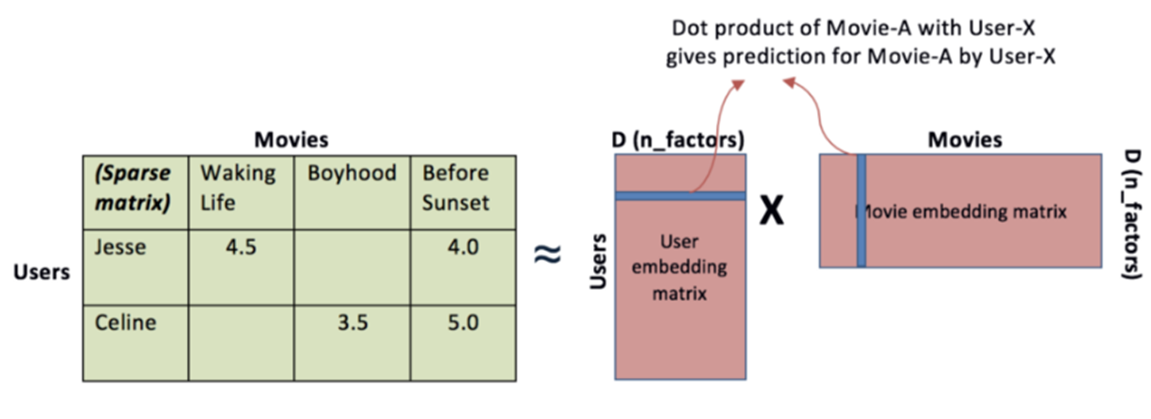

### Matrix Factorisation works on the principle that we can learn the user and the item embeddings, and then predict the rating for each user-item by performing a dot (or scalar) product between the respective user and item embedding. 



In [80]:
# Applying matrix factorization: declare the output as being the dot product between the two embeddings: items and users
y = Dot(1, normalize=False)([user_vecs, item_vecs])

time: 6.54 ms


# 2. Deep Recommender

### Instead of taking a dot product of the user and the item embedding, concatenate or multiply them and use them as features for a neural network. 
### Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.

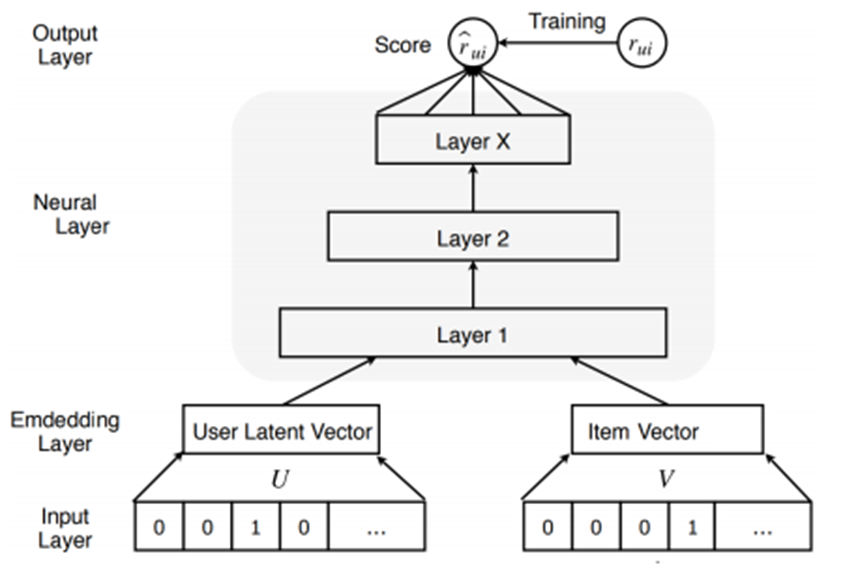






## Check Performance

I searched around deep network architecture and checked:
- What happens if I add other layers on top of the first one? 
- What happens if I increase or decrease the embedding size? 
- What happens if I add dense layers on top of the embeddings before merging?
- What happens if I change the number of hidden units in each dense layer?
- What happens if I change the number of epochs?  
- What happens if I use Dropout or not?

Modifications are commented in the code below

### Here is the model representation for deep neural network.

In [ ]:
# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation='relu')(user_vecs) 
item_vecs = Dense(64, activation='relu')(item_vecs)
price_vecs = Dense(64, activation='relu')(price_vecs) 
title_vecs = Dense(64, activation='relu')(title_vecs)

In [ ]:
# Concatenate the item embeddings :
item_vecs_complete  = Concatenate()([item_vecs, price_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network:
input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply
#input_vecs = Concatenate()([user_vecs, item_vecs]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network:
#input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat 

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)  

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
# x = Dense(64, activation='relu')(x) # Add dense again or not 
# x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

###### declare a model that takes items and users as input and output y, our prediction.

In [ ]:
model = Model(inputs=
                    [user_id_input,
                      item_id_input,
                      price_id_input,
                      title_id_input,
                     ], 
              outputs=y)


### compile the model with 'mse' loss, and "adam" loss optimization
### I would optimise the model such that I minimise the mean squared error ('mse') on the ratings from the train set.
### The Adam optimization algorithm used, is an extension to stochastic gradient

In [ ]:
model.compile(loss='mse',
              optimizer="adam" )


### Save different histories and best models using keras ModelCheckpoint callback


In [ ]:
save_path = "./models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
# modname = 'dense_2_15_embeddings_2_epochs' + mytime 
modname = 'dense_2_15_embeddings_2_epochs'

thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename, monitor='val_loss', save_best_only=True)

### Train the model by calling the model’s fit method

When training the model, the embeddings parameters are learnt too.

Use the internal keras random cross validation scheme (the validation_split=0.1 parameter below) instead of the test set to evaluate the models 

The test set will be kept to verify the quality of recommendations at the end.

# *** Set model fit

In [ ]:
history = model.fit([ratings_train["user_id"]
                    , ratings_train["item_id"]
                    , ratings_train["price_id"]
                    , ratings_train["title_id"]
                    ]
                    , ratings_train["score"]
                    , batch_size=64
                    , epochs=2
                    , validation_split=0.2
                    , callbacks=[mcheck]
                    , shuffle=True)

### Save the fitted model history to a file

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss: dense_2_15_embeddings_2_epochs')
    plt.legend()
    plt.savefig(modname+'_loss_validation_acc.jpg')

In [ ]:
history.history

In [ ]:
plot_history(history)

In [ ]:
# modname='dense_2_15_embeddings_2_epochs'  
modname = modname

with open('./histories/' + modname + '.pkl' , 'wb') as file_pi:  
    pickle.dump(history.history, file_pi)



## Compare the results of matrix factorization and different configurations of neural networks:


In [ ]:
def disp_model(path,file,suffix):
    model = load_model(path+file+suffix)    
    ## Summarise the model 
    model.summary()    
    # Extract the learnt user and item embeddings, i.e., a table with number of items and users rows and columns, with number of columns is the dimension of the trained embedding.
    # In our case, the embeddings correspond exactly to the weights of the model:
    weights = model.get_weights()
    print ("embeddings \ weights shapes",[w.shape for w in weights])    
    return model
    
# model_path = "./models/save/"
model_path = "./models/"

### Running the model and looking at the corresponding history I get the following 
plots of the training  MSE loss for the different the embedding and epoches sizes :

In [ ]:
def plt_pickle(path,file,suffix):
    with open(path+file+suffix , 'rb') as file_pi: 
        thepickle= pickle.load(file_pi)
        plot(thepickle["loss"],label ='Train Error ' + file,linestyle="--")
        plot(thepickle["val_loss"],label='Validation Error ' + file) 
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Error")  
        ##plt.ylim(0, 0.1)
    return pd.DataFrame(thepickle,columns =['loss','val_loss'])

hist_path = "./histories/"

In [ ]:
model=disp_model(model_path , modname , '.h5')

In [ ]:
model

In [ ]:
# Display the model using keras
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
x=plt_pickle(hist_path , modname , '.pkl')
x.head(20).transpose()
print("modname:", modname)